# *AutoARIMA* para previsão de produção de energia na China

Não é nenhuma novidade a força da economia chinesa. A China é o país mais populoso do mundo, com o maior crescimento econômico do mundo e, além disso, é um dos maiores consumidores e produtores de energia do mundo. O rápido crescimento da economia chinesa fez crescer a demanda por energia e alternativas para a sua produção incentivadas, principalmente, por políticas governamentais. Entre os anos de 2000 a 2011 o gigante oriental registrou uma taxa de crescimento médio de 10% ao ano, mas que em seguida sofreu uma desaceleração. Mesmo com a pandemia do coronavírus, no anos de 2020, a China apresentou uma taxa de crescimento de 6%. Por conta da forte demanda de energia a China tem buscado atrair investimentos privados, melhorando sua infraestrutura de transmissão para conectar centros de oferta e demanda de energia e acelerando a aprovação de projetos.

Os maiores fornecedores de energia são o carvão e o petróleo, porém o país ainda diversificou o fornecimento de energia utilizando fontes hidrelétricas, gás natural, energia nuclear e outras formas de energias renováveis. Visando reduzir a emissão de gases poluentes já existe uma política no país de limitar o uso do carvão e aumentar a participação de energia nuclear, energia renovável e gás natural como substitutos ao carvão.

No ano de 2018 a capacidade de produção de energia elétrica da China era de 1.9 terawatts (TW) e ainda esteve em crescimento. Conforme dados do governo chinês em Abril de 2021 foram produzidos 623 bilhões de KWh de eletricidade, um aumento de 11% em relação ao ano de 2020 e de 11.3% em relação ao ano de 2019. Estima-se que a geração de energia média foi de 20.77 KWh. Dentre as fontes de energia na produção houve registro de crescimento das fontes eólicas, térmicas, hidroelétrica e nuclear, porém queda de fontes solares.

## Objetivo

Usar o método *AutoARIMA* da linguagem *Python* para realizar previsão da produção de energia elétrica na China.

## Importando das bibliotecas

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt
%matplotlib inline

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
from pmdarima.arima import ADFTest


## Importando da base de dados

Os dados foram obtidos no site do *FED* (FRED) e tratam da produção de energia elétrica total gerada na China. Os dados vão de Janeiro de 1991 até Maio de 2021 (quase 30 anos) e possui uma periodicidade mensal. A escala dos dados está em GigaWatts-horas (GWn) e não possuem ajuste sazonal. A base de dados pode ser obtida [nesse link](https://fred.stlouisfed.org/series/CHNPRENEL01MLM).



In [9]:
dateparse= lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')
data=pd.read_csv('CHNPRENEL01MLM.csv',parse_dates=['DATE'],index_col='DATE',date_parser=dateparse)
data.head()

Visualizando a base de dados.

In [11]:
data.head(10)

,CHNPRENEL01MLM
DATE,
1999-01-01,110140.0
1999-02-01,81410.0
1999-03-01,99010.0
1999-04-01,93990.0
1999-05-01,96920.0
1999-06-01,105460.0
1999-07-01,107120.0
1999-08-01,107250.0
1999-09-01,100360.0


Últimas observações da série.

In [24]:
data.tail(24)

,CHNPRENEL01MLM
DATE,
2019-06-01,583400.0
2019-07-01,657300.0
2019-08-01,668200.0
2019-09-01,590800.0
2019-10-01,571400.0
2019-11-01,589000.0
2019-12-01,654400.0
2020-01-01,513300.0
2020-02-01,513300.0


Dimensão da base de dados : tempos 1 coluna com 269 observações.

In [13]:
data.shape

(269, 1)

Informações sobre a base de dados: todos os valores são do tipo *float64*, valores numéricos e não inteiros (com casas decimais).

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 269 entries, 1999-01-01 to 2021-05-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CHNPRENEL01MLM  269 non-null    float64
dtypes: float64(1)
memory usage: 4.2 KB


Abaixo podemos ver a tabela estatística.

In [15]:
data.describe()

,CHNPRENEL01MLM
count,269.000000
mean,337464.223494
std,169930.608452
min,81410.000000
25%,180950.000000
50%,334498.000000
75%,476720.000000
max,727700.000000


**Visualizando a série temporal**

A função *tsdisplay* gerar gráficos úteis para a análise da série temporal, como:

1) O gráfico propriamente dito da série temporal, onde observa-se a presença de tendência global (ao longo de toda a série) e presença de sazonalidade (que no início da série é mais fraca, mas entre a 100ª e a 150ª observação vai se tornando mais forte.

2) Gráfico da função de autocorrelação serial, que mostra o quanto uma observação é correlacionada com as suas defasagens. É uma bom indicativo para visualizar se uma série é ou não estacionário. No nosso caso há uma forte evidência de não estacionariedade da série de produção de energia chinesa.

3) O gráfico de distribuição que nos revela que a série não possui uma distribuição normal. Conforme o gráfico a maioria das observações da série parecem estar abaixo do valor de 400.000 GWh.

C:\Users\junio\Anaconda3\lib\site-packages\pmdarima\utils\visualization.py:222: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


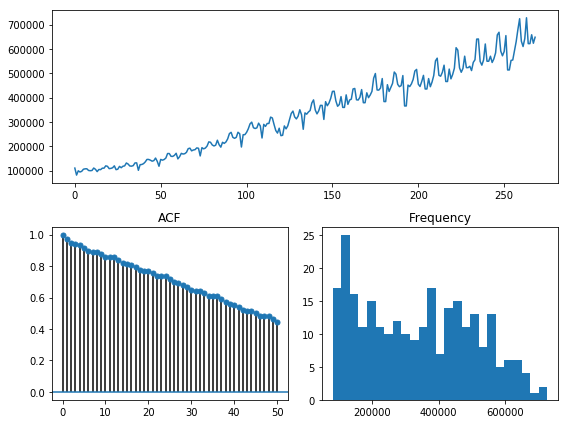

In [213]:
tsdisplay(data)

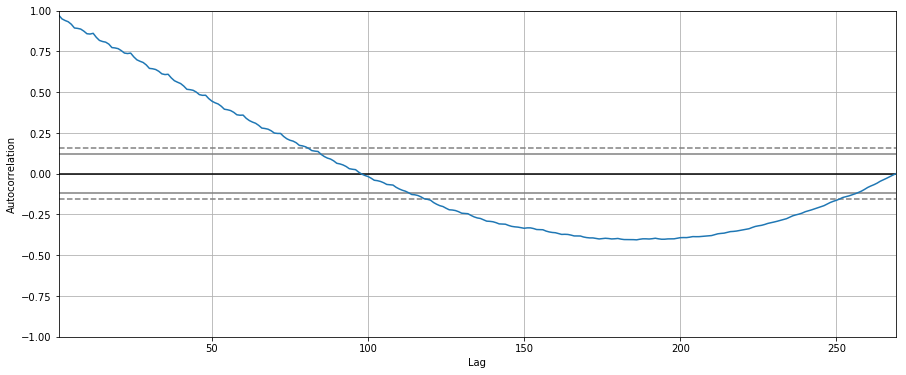

In [51]:
autocorr_plot(data)

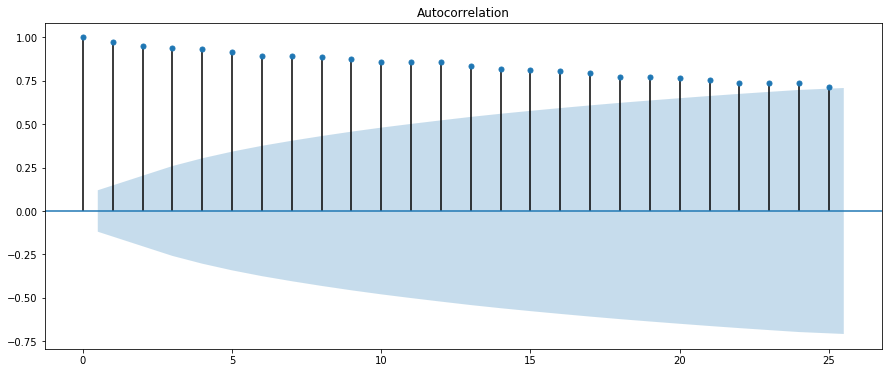

In [63]:
plot_acf(data, alpha=0.05);

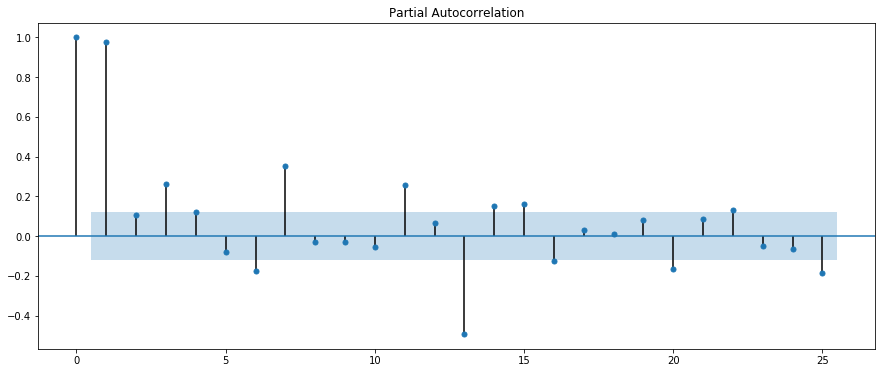

In [64]:
plot_pacf(data, alpha=0.05)

## Aplicando o AutoARIMA

Geralmente, para usar modelos ARIMA, é preciso aplicar a metodologia *Box-Jenkins* que são um conjunto de etapas (Identificação, Estimação e Diagnóstico dos resíduos) para escolher qual o melhor modelo e gerar previsões para a série temporal. Uma forma de automatizar parte desse processo é usar o *AutoARIMA* que escolhe os melhores parâmetros *p*,*d* e *q* e, para presença de sazonalidade na série temporal, os parâmetros *P*, *D* e *Q*. Essa função é bastante conhecida na linguagem *R*, porém a biblioteca *PMDArima* é uma alternativa dessa função na linguagem *Python*.

Assim sendo, escolherei os parâmetros *p* (componente autorregressivo da série e que vai variar entre 1 e 6) , *d* (componente de integração e será 1 e o máximo, por padrão, será 2), *q* (componente de médias móveis e que vai variar entre 1 e 6), *P* (componente autorregressivo da sazonalidade, que vai de 1 a 2), *D* (componente de integração da sazonalidade), *Q* (componente de médias móveis da sazonalidade e que vai de 1 a 2) e *m* (periodicidade da sazonalidade que no nosso caso é 12).

Vamos agora aplicar o processamento do *autoARIMA*.

Vamos atribuir a uma variável o *autoARIMA*, que gerará vários modelos ARIMA e os seus respectivos AIC's e BICS (critérios de informação).

In [107]:
stepwise=auto_arima(data,
                    start_p=0,
                    start_q=0,
                    d=0,
                    max_p=6,
                    max_q=6,
                    max_d=2,
                    start_P=1,
                    start_Q=1,
                    D=1,
                    max_P=2, max_D=1, max_Q=2, max_order=5,
                    m=12,
                    seasonal=True,
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(1,1,1,12) [intercept=True]; AIC=5805.674, BIC=5819.870, Time=0.358 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=5845.494, BIC=5852.592, Time=0.019 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=5685.697, BIC=5699.893, Time=0.167 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=5732.615, BIC=5746.811, Time=0.175 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=6080.994, BIC=6084.543, Time=0.021 seconds
Fit ARIMA(1,0,0)x(0,1,0,12) [intercept=True]; AIC=5712.013, BIC=5722.661, Time=0.045 seconds
Fit ARIMA(1,0,0)x(2,1,0,12) [intercept=True]; AIC=5678.246, BIC=5695.992, Time=0.787 seconds
Fit ARIMA(1,0,0)x(2,1,1,12) [intercept=True]; AIC=5667.914, BIC=5689.208, Time=1.134 seconds
Fit ARIMA(1,0,0)x(1,1,1,12) [intercept=True]; AIC=5665.930, BIC=5683.675, Time=0.523 seconds
Fit ARIMA(1,0,0)x(0,1,1,12) [intercept=True]; AIC=5666.305, BIC=5680.501, Time=0.256 seconds
Fit ARIMA(1,0,0)x(1,1,2,12

O modelo que foi gerado é um *SARIMA*(1,0,1)x(0,1,1,12).

In [128]:
stepwise

ARIMA(order=(1, 0, 1), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)

Esse foi o model com menor *AIC* gerado.

In [130]:
print(stepwise.aic())
print(stepwise.bic())

4838.94642051721
4855.937234024798


## Separando os dados de treino e de teste

Vamos agora usar o *autoARIMA* para gerar uma validação do modelo. Para isso iremos separar os dados em treino e teste. Os dados de treino serão usado para treinar o *autoARIMA* e os dados de teste para comparar com as preisões geradas. Vamos separar as 12 últimas observações para dados de teste.

Irei colocar os dados de treino de janeiro de 1985 até janeiro de 2016 e os dados de teste será de fevereiro de 2016 em diante.

In [194]:
treino=data.loc['1991-01-01':'2018-05-01']
teste=data.loc['2018-06-01':]

In [195]:
teste

,CHNPRENEL01MLM
DATE,
2018-06-01,555100.0
2018-07-01,640000.0
2018-08-01,640500.0
2018-09-01,548300.0
2018-10-01,533000.0
2018-11-01,554300.0
2018-12-01,620000.0
2019-01-01,549100.0
2019-02-01,549100.0


Vamos treinar os modelos que geramos.

In [196]:
stepwise.fit(treino)

ARIMA(order=(1, 0, 1), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)

Vamos gerar as previsões de cada modelo.

In [199]:
previsao=stepwise.predict(n_periods=36)

Transformando as previsões em um *dataframe*.

In [200]:
previsao=pd.DataFrame(previsao,index=teste.index, columns=['previsão modelo 1'])

Visualizando o *dataset* de previsões.

In [201]:
previsao.head(10)

,previsão modelo 1
DATE,
2018-06-01,556166.381027
2018-07-01,621171.160967
2018-08-01,617158.982626
2018-09-01,547481.305824
2018-10-01,533989.254336
2018-11-01,548573.937906
2018-12-01,588778.454307
2019-01-01,529760.169810
2019-02-01,529201.761006


Comparando graficamente os valores reais com as previsões, vemos que os resultados das previsões parecem acompanhar bem o valores reais.

<Figure size 1440x360 with 0 Axes>

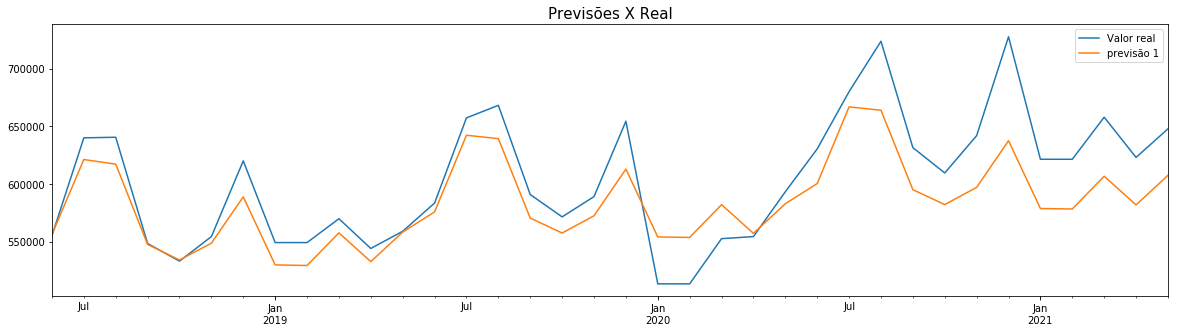

In [202]:
plt.figure(figsize=(20,5))
pd.concat([teste,previsao],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.legend(['Valor real','previsão 1','previsão 2']);

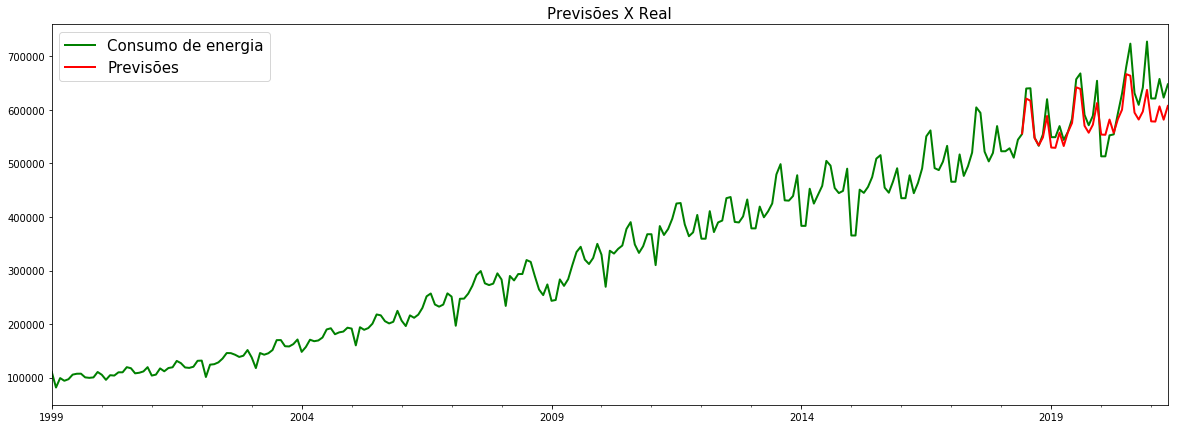

In [203]:
pd.concat([data,previsao],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Consumo de energia','Previsões'], fontsize=15)
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.show();

## Sumário dos modelos

Abaixo podemos conferir os sumários dos modelos com seus coeficientes, estatísticas e p-valores.

Podemos ver que no sumário em *model* que no valor do *D* está [1,2], ou seja, já está informando a possibilidade de ser com *D* igual a 1 ou *D* igual a 2, mas o restante do sumário diz respeito ao modelo 1.

In [204]:
stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  233
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -2414.473
Date:                            Wed, 25 Aug 2021   AIC                           4838.946
Time:                                    01:33:50   BIC                           4855.937
Sample:                                         0   HQIC                          4845.807
                                            - 233                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7234.8012   2057.529      3.516      0.000    3202.119    1.13e+04
ar.L1          0.7069      0.077      9.172      0.000       0.556       0.858
ma.L1         -0.2698      0.127     -2.121      0.034      -0.519      -0.020
ma.S.L12      -0.4747      0.042    -11.412      0.000      -0.556      -0.393
sigma2      1.926e+08      0.050   3.87e+09      0.000    1.93e+08    1.93e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.94   Jarque-Bera (JB):                60.68
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.14e+25. Standard errors may be unstable.
"""

## Avaliação dos modelos

Uma das principais etapas é a avaliação dos modelos. Primeiramente vamos olhar o *rmse* que é umas das principais métricas para análise dos erros, onde ele compara valores reais com os preditos. Aqui é interessante que o resultado seja o mais próximo possível de zero.

Podemos ver que o modelo com melhor desempenho foi o modelo 1.

In [205]:
print("RMSE do modelo 1: %.3f" % np.sqrt(mean_squared_error(teste, previsao)))
print("R² do modelo 1: %.3f" % r2_score(teste, previsao))

RMSE do modelo 1: 32275.713
R² do modelo 1: 0.646


## Análise dos resíduos

Podemos usar também a função *plot_diagnostic* para gerar os resíduos, o histograma dos resíduos, o gráfico QQ e o correlograma dos resíduos.

Para o modelo *stepwise* podemos ver que os resíduos apresentam estar flutuando em torno do valor de zero e o seu histograma apresenta possuir um formato de sino. Vemos que o *KDE* do histograma está bem próximo do *KDE* de uma distribuição normal. No gráfio QQplot os valores estão, em sua maioria, em cima da linha vermelha, o que é uma evidência para normalidade; e por fim o correlograma não apresentou resultados estatisticamente significativo, rejeitando, então, a presença de autocorrelação serial.

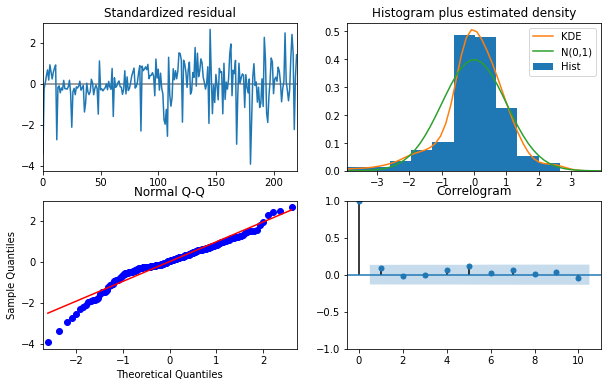

In [206]:
stepwise.plot_diagnostics(figsize=(10,6));

### Teste de normalidade dos resíduos

Para sabermos se a distribuição dos resíduos é ou não normal precisaremos realizar um teste estatístico chamado Teste de Normalidade *Jarque-Bera*. O teste Jarque-Bera testa se a distribuição dos dados é uma distribuição normal ($H_{0}$) em comparação com uma hipótese alternativa ($H_{1}$) em que os dados seguem alguma outra distribuição. A estatística do teste é baseada em dois momentos dos dados, a assimetria e a curtose, e possui uma $\chi^{2}_{2;1-\alpha}$ distribuição assintótica.

A estatística do teste Jarque-Bera é dada pela equação abaixo:

$S_{JB} = T\bigg[\frac{\alpha_{1}^{2}}{6} + \frac{\big(\alpha_{2} - 3\big)^{2}}{24} \bigg]$, onde $\alpha_{1}$ é o coeficiente de assimetria e $\alpha_{2}$ o coeficiente de curtose.

Se $S_{JB} > \chi^{2}_{2;1-\alpha}$, devemos rejeitar $H_{0}$.

Para o primeiro modelo o *p-value* teve um valor de 0.4377, bem acima do nível de significância de 5% (que será o nosso padrão). Então podemos considerar que os resíduos do modelo 1 possuem uma distribuição normal.

In [208]:
erros1 = teste['CHNPRENEL01MLM'] - previsao['previsão modelo 1']
jb1 = jarque_bera(erros1)
print('Estatística Jarque-Bera :', jb1[0])
print('p-valor :', jb1[1])
print('Assimetria :', jb1[2])
print('Curtose :',jb1[3])

Estatística Jarque-Bera : 1.6521800060272893
p-valor : 0.43775757524285186
Assimetria : -0.11198753268800252
Curtose : 4.025323611081565


## Previsão

Dado que temos um modelo selecionado podemos treiná-lo novamente, mas com todos os dados e gerar as previsões para um período de tempo fora do período especificado da base de dados. 

In [41]:
stepwise.fit(data)

ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 2, 12), suppress_warnings=True)

Vamos criar 24 previsões para um futuro fora da séries original.

In [209]:
previsao2=stepwise.predict(n_periods=12)
previsao2=pd.DataFrame(future_forecast2, 
                              index=pd.date_range(start='2021-06-01',
                                                  end='2022-05-01', freq='MS'),
                              columns=['nova previsão'])

Vamos observar essas novas previsões.

In [210]:
previsao2.head(24)

,nova previsão
2021-06-01,684079.535694
2021-07-01,747010.608682
2021-08-01,777424.568048
2021-09-01,689923.827080
2021-10-01,671884.857085
2021-11-01,699543.981576
2021-12-01,776011.080088
2022-01-01,675418.909568
2022-02-01,675846.620655
2022-03-01,713195.660712


E agora vamos ver graficamente.

<Figure size 1440x360 with 0 Axes>

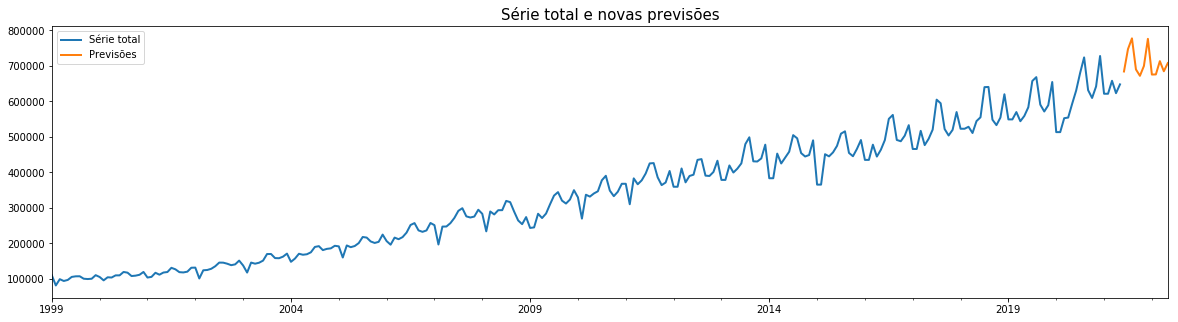

In [211]:
plt.figure(figsize=(20,5))
pd.concat([data,previsao2],axis=1).plot(figsize=(20,5), linewidth=2)
plt.xlabel('')
plt.title('Série total e novas previsões',size=15)
plt.legend(['Série total','Previsões'])
plt.show();

http://www.stats.gov.cn/english/PressRelease/202105/t20210518_1817631.html

https://www.eia.gov/international/analysis/country/CHN